# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../traffic-signs-data/train.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

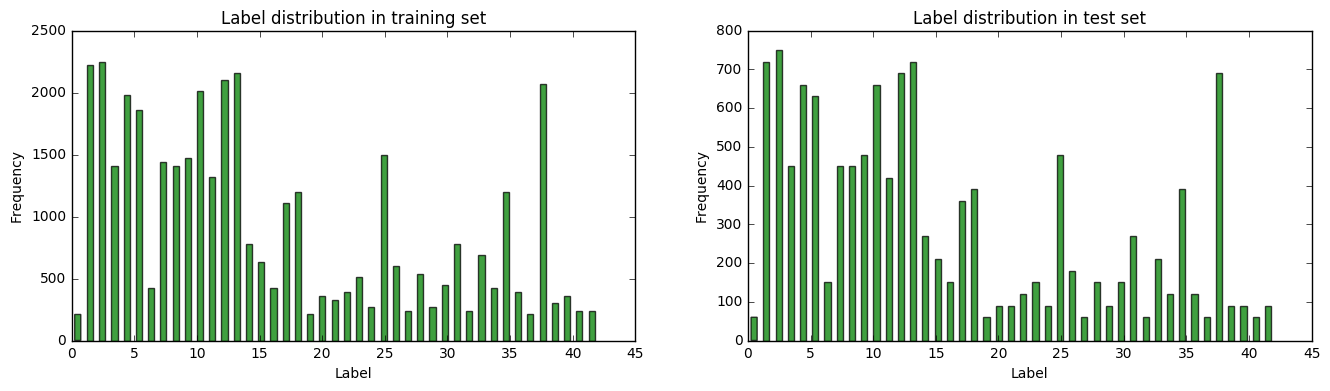

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import math
# Visualizations will be shown in the notebook.
%matplotlib inline

# distribution of classes in training and sets
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 4))

ax0.hist(y_train, n_classes, histtype='bar', facecolor='g', alpha=0.75, rwidth=0.5)
ax0.set_title('Label distribution in training set')
ax0.set_xlabel('Label')
ax0.set_ylabel('Frequency')

ax1.hist(y_test, n_classes, histtype='bar', facecolor='g', alpha=0.75, rwidth=0.5)
ax1.set_title('Label distribution in test set')
ax1.set_xlabel('Label')
ax1.set_ylabel('Frequency')

plt.show()

# read label codes from csv
import pandas as pd
sign_names_df = pd.read_csv('signnames.csv')
classIdToSignNameDict = sign_names_df.set_index('ClassId').to_dict()['SignName']    

Grab one image per class in training set...
Show sample images and classes


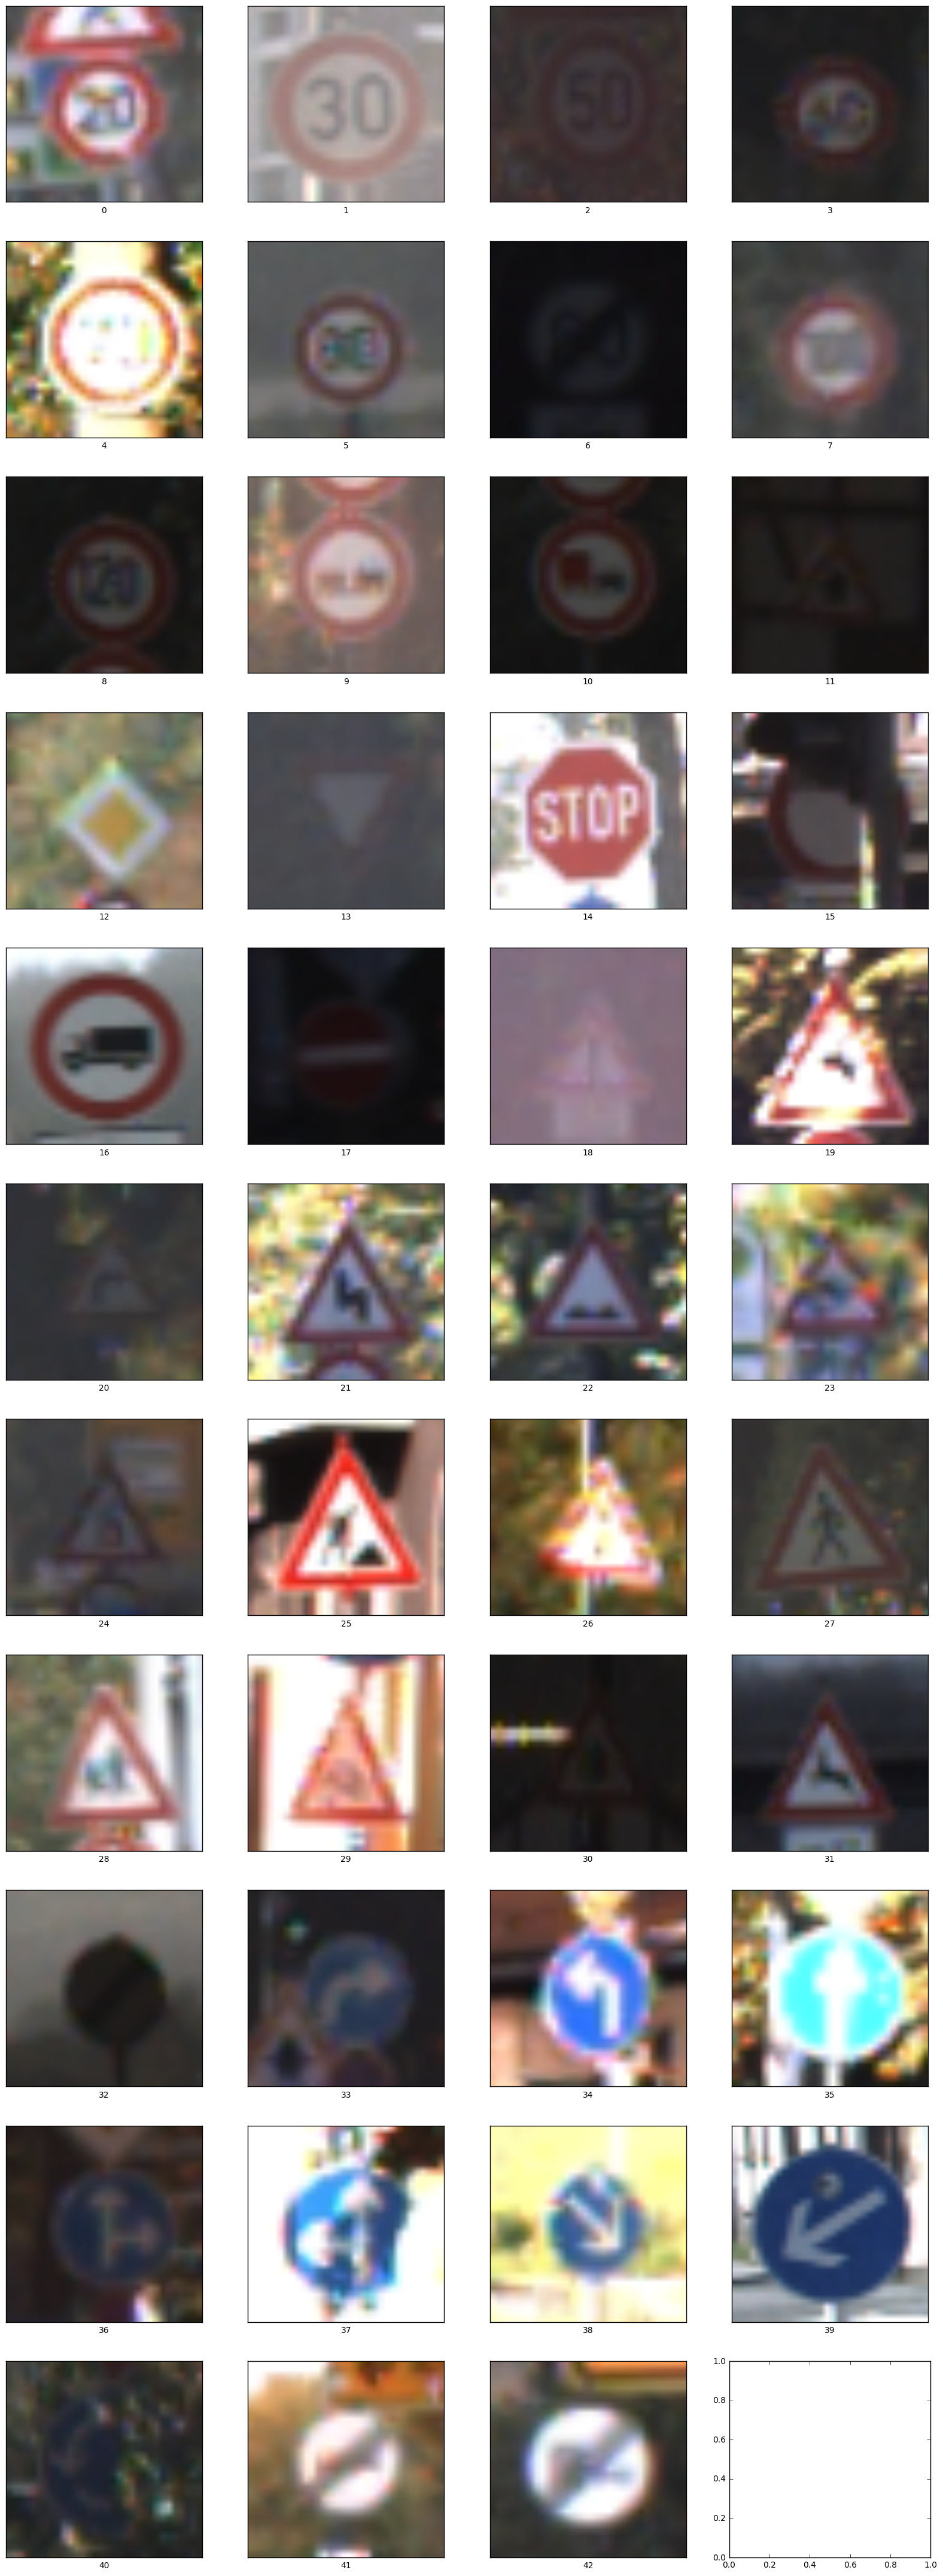

In [4]:
def show_images(images, titles, cols):
    assert len(images) == len(titles)
    num_images = len(images)
    rows = math.ceil(num_images/cols)
    fig, axes = plt.subplots(rows, cols)
    fig.set_figheight(rows * 5)
    fig.set_figwidth(cols * 5)
    idx = 0
    for i, ax in enumerate(axes.flat):
        if idx < num_images:
            ax.imshow(images[idx])            
            ax.set_xlabel(titles[idx])
            ax.set_xticks([])
            ax.set_yticks([])
            idx = idx + 1
    plt.show()

print("Grab one image per class in training set...")
sample_examples = {}
for idx in range(n_train):
    if y_train[idx] not in sample_examples:
        sample_examples[y_train[idx]] = X_train[idx]
images = []
titles = []
for key in sorted(sample_examples):
    titles.append(key)
    images.append(sample_examples[key])
print("Show sample images and classes")
show_images(images, titles, 4)

**Observations:**
1. There is a huge variance in the amount of data available per class. For example class es 1,2,4 have > 2000 training samples, but classes 0,5,20 have < 500 training samples. Because of this, I expect the model to have better accuracy for classes with more training data, and lower accuracy for classes with less training data.
2. Many images in the training and test set have poor lighting, and its hard for even human eye to recognize these sometimes. 
3. I am going to augment the images by applying random rotations, translations and shear to the image.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Data Augmentation:
The volume of training data we have is not sufficient. I am augmenting data by rotating image, applying shear and varying brightness of the image. I am increasing training data 3x by doing this.

Code to agument data is below...

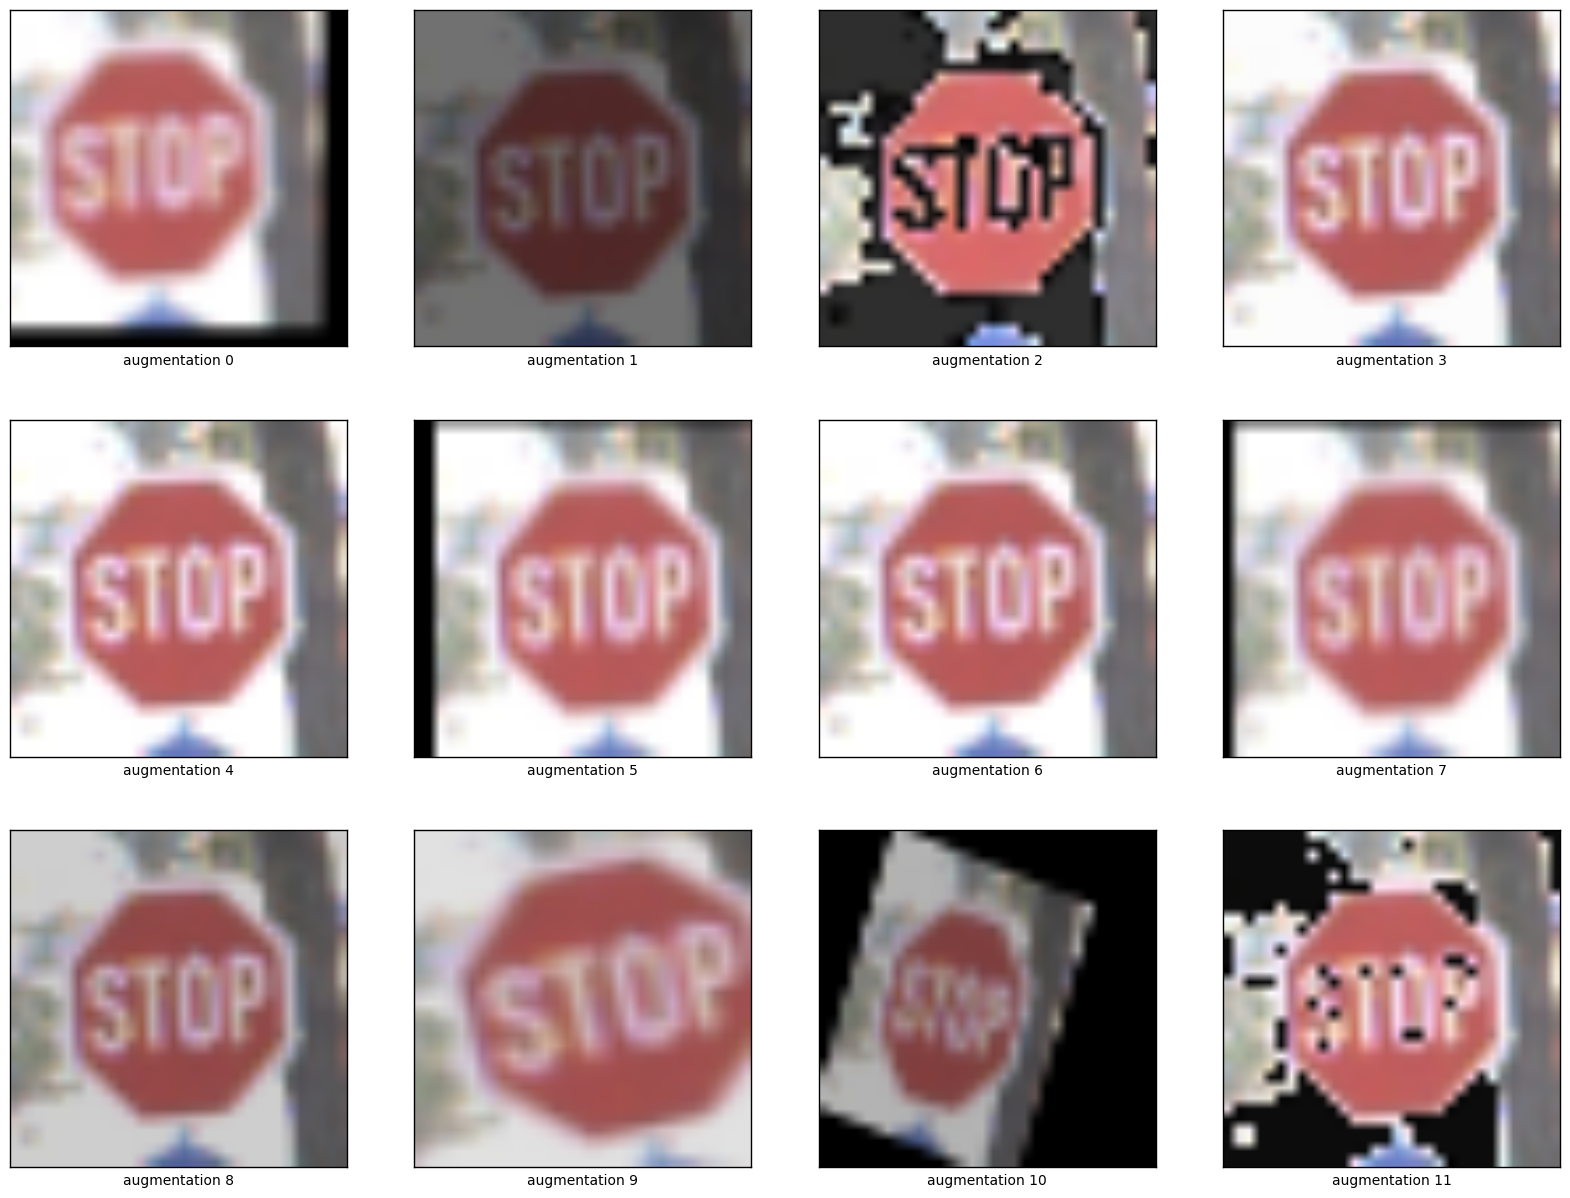

In [5]:
### Generate data additional data (OPTIONAL!)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

import numpy as np
%matplotlib inline
import matplotlib.image as mpimg

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def augment_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)

    if np.random.random() > 0.5:
        rand_int = np.random.randint(low=1, high=4)
        if rand_int == 1:
            img = cv2.warpAffine(img,Rot_M,(cols,rows))
        if rand_int == 2:
            img = cv2.warpAffine(img,Trans_M,(cols,rows))
        if rand_int == 3:
            img = cv2.warpAffine(img,shear_M,(cols,rows))

    # Brightness
    if brightness == 1 and np.random.random() > 0.5:
        img = augment_brightness_camera_images(img)

    return img

sample = sample_examples[14]
augmented_samples = []
titles = []
for i in range(12):
    augmented_sample = augment_image(sample,20,10,5,brightness=1)
    augmented_samples.append(augmented_sample)
    titles.append("augmentation %d"%i)

show_images(augmented_samples, titles, 4)

Before augmentation...
Training data size:  39209
Training data size:  12630
After augmentation...
Number of training examples = 117627
Number of testing examples = 12630


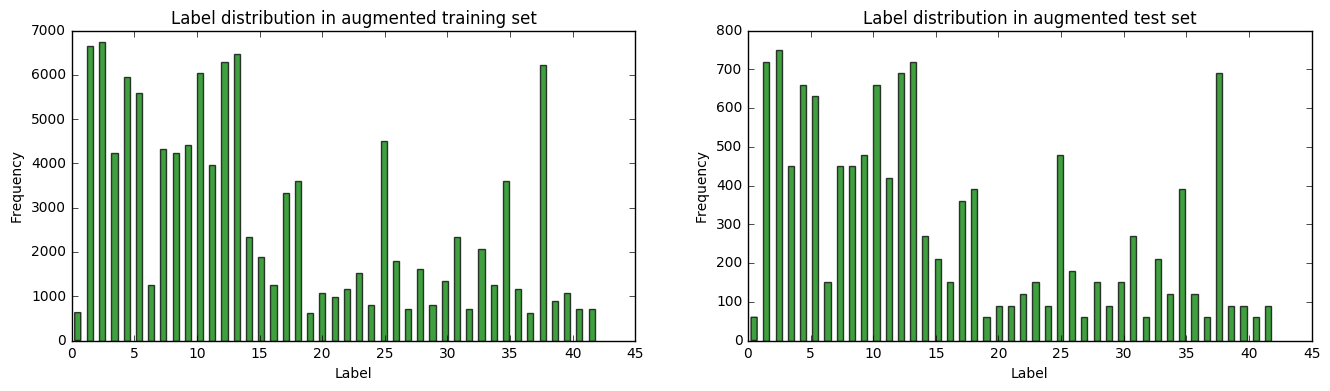

In [6]:
from collections import Counter
def augment_data(X, y):    
    ### augment samples
    augmented_X = []
    augmented_y = []
    num_examples = X.shape[0]
    for idx in range(num_examples):
        img = X[idx]
        label = y[idx]
        ### add original image and label
        for i in range(3):
            augmented_X.append(augment_image(img,20,10,5,brightness=1))
            augmented_y.append(label)
            
    augmented_X = np.asarray(augmented_X)
    augmented_y = np.asarray(augmented_y)
    return (augmented_X, augmented_y)

print("Before augmentation...")
print("Training data size: ", X_train.shape[0])
print("Training data size: ", X_test.shape[0])

# augment train data
# Not augmenting test data
(X_train, y_train) = augment_data(X_train, y_train)

print("After augmentation...")
print("Number of training examples =", y_train.shape[0])
print("Number of testing examples =", y_test.shape[0])

# distribution of classes in training and sets
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 4))

ax0.hist(y_train, n_classes, histtype='bar', facecolor='g', alpha=0.75, rwidth=0.5)
ax0.set_title('Label distribution in augmented training set')
ax0.set_xlabel('Label')
ax0.set_ylabel('Frequency')

ax1.hist(y_test, n_classes, histtype='bar', facecolor='g', alpha=0.75, rwidth=0.5)
ax1.set_title('Label distribution in augmented test set')
ax1.set_xlabel('Label')
ax1.set_ylabel('Frequency')

plt.show()




In [7]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

### Set up train, test and validation data
from sklearn.model_selection import train_test_split

### and split the data into training/validation/testing sets here.
### split train into train (90%) and validation(10%)
### This will leave us in all with 
### train set at (0.9*0.75) 67.5%, 
### validation set at (0.1*0.75) 7.5% 
### and test set at 25% 
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=832289)

print("Training examples shape =", X_train.shape)
print("Training labels shape =", y_train.shape)
print("Validation examples shape =", X_val.shape)
print("Validation labels shape =", y_val.shape)
print("Test examples shape =", X_test.shape)
print("Test labels shape =", y_test.shape)

Training examples shape = (105864, 32, 32, 3)
Training labels shape = (105864,)
Validation examples shape = (11763, 32, 32, 3)
Validation labels shape = (11763,)
Test examples shape = (12630, 32, 32, 3)
Test labels shape = (12630,)


In [8]:
def make_zero_mean(imgs):
    return (imgs - 128.) / 255.

sample_example = X_train[0]
print("Sample before normalization...")
print(X_train[0])

X_train = make_zero_mean(X_train)
X_val = make_zero_mean(X_val)
X_test = make_zero_mean(X_test)

print("Sample after normalization...")
print(X_train[0])




Sample before normalization...
[[[14 14 14]
  [26 26 25]
  [25 25 24]
  ..., 
  [17 14 14]
  [15 14 14]
  [15 14 14]]

 [[13 14 13]
  [23 24 23]
  [22 23 22]
  ..., 
  [27 24 23]
  [25 23 23]
  [26 24 24]]

 [[13 13 13]
  [22 23 22]
  [23 23 22]
  ..., 
  [27 25 24]
  [25 23 23]
  [25 23 23]]

 ..., 
 [[20 20 19]
  [22 21 20]
  [23 22 20]
  ..., 
  [27 25 25]
  [26 24 24]
  [16 14 14]]

 [[23 23 22]
  [25 25 23]
  [25 25 23]
  ..., 
  [27 25 25]
  [25 23 23]
  [15 13 13]]

 [[14 13 13]
  [14 15 14]
  [13 14 13]
  ..., 
  [25 24 24]
  [23 22 22]
  [13 12 12]]]
Sample after normalization...
[[[-0.44705882 -0.44705882 -0.44705882]
  [-0.4        -0.4        -0.40392157]
  [-0.40392157 -0.40392157 -0.40784314]
  ..., 
  [-0.43529412 -0.44705882 -0.44705882]
  [-0.44313725 -0.44705882 -0.44705882]
  [-0.44313725 -0.44705882 -0.44705882]]

 [[-0.45098039 -0.44705882 -0.45098039]
  [-0.41176471 -0.40784314 -0.41176471]
  [-0.41568627 -0.41176471 -0.41568627]
  ..., 
  [-0.39607843 -0.40784314

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

### NEEDS EDITING
**Answer:**

All images are nicely preprocessed to 32x32x3 size for us.

Since color plays an important role in identifying traffic sign, I am retaining all the RGB values instead of coverting to gray scale image.

Finaly, I normalized feature values of all three channels to have a mean of 0 and very small sigma. This well conditioned data will help gradient descent reach minima quickly and reliably. Since these values all range from [0, 255], I applied a simple normalization of :

val = (val - 128 ) / 255

This will make the mean 0, and values range [-0.5, 0.5]. I converted label to one-hot encoding.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
The original test data set contains approximately 25% of the total data, and training dataset has 75%.

I used 10% of training data set as validation dataset. The other 90% is used as training dataset. I retained all the testing data provided as test dataset. 

train set = 0.9 * 0.75 = 67.5% of all data

validation set = 0.1 * 0.75 = 7.5% of all data

test set = 25% of all data


In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def PierreYannLikeArchitecture(x, mu, sigma, nclasses, keep_prob):
    # Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 30x30x32, Output = 10x10x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='VALID')
#     conv1 = tf.nn.dropout(conv1, keep_prob)

    # Flatten. Input = 10x10x32. Output = 3200
    flat_c1 = flatten(conv1)

    # Convolutional. Input = 10x10x32 Output = 8x8x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 8x8x64. Output = 4x4x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
#     conv2 = tf.nn.dropout(conv2, keep_prob)

    # Flatten. Input = 4x4x64. Output = 1024.
    flat_c2 = flatten(conv2)
    
    # Convolutional. Input = 4x4x64 Output = 2x2x128.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(128))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation.
    conv3 = tf.nn.relu(conv3)

    # Pooling. Input = 2x2x128. Output = 1x1x128
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
#     conv3 = tf.nn.dropout(conv3, keep_prob)

    # Flatten. Input = 1x1x128. Output = 128.
    flat_c3 = flatten(conv3)
        
    # Join flat layers from flat_c1, flat_c2 and flat_c3. Inputs 3200, 1024, 128. Output = 4352.
    flat_combined = tf.concat(1, [flat_c1, flat_c2, flat_c3])
    
    # Layer 3: Fully Connected. Input = 4352. Output = 1024.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(4352, 1024), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1024))
    fc1   = tf.matmul(flat_combined, fc1_W) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)    
    # Dropout layer
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 1024. Output = 1024.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(1024, 1024), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(1024))
    fc2   = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2 = tf.nn.relu(fc2)    
    # Dropout layer
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 1024. Output = nclasses.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(1024, nclasses), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(nclasses))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Activation.
    logits = tf.nn.relu(fc3)

    return logits    

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I am using a conv net architecture similar to the one described in Pierre Sermanet and Yann LeCun's paper referrenced above.
Each input image is a 32x32x3 image. 

I apply a 5x5 convolution on it with 6 feautres, which gives a 28x28x6 output. On top of this, I subsample by max pooling, which gives me 14x14x6 output. Lets call this layer 1.

Another 5x5 convolution on output of layer1 with 16 out features gets me to a 10x10x16 output. Applying maxpool subsampling down converts this to 5x5x16 output. Lets call this layer 2.

Another 3x3 convolution on output of layer 2 with  30 output features gets me to a 3x3x30 output. Lets call this layer 3.

I flatten:
layer 1 output to get flat vector of size 14x14x6 = 1176
layer 2 output to get flat vector of size 5x5x16 = 400
layer 3 output to get flat vector of size 3x3x30 = 270
I add dropout of 0.5 for each one of the flat layers above and combine the three flat vectors to form a vector of size 1176 + 400 + 270 = 1846

After this there are 2 fully connected layers.
First fully connected layer connects 1846 features to 200. And I added a dropout of 0.5 there.
Finally there is the last fully connected layer that connects 200 features to 43 features, which is the number of classes. This layer can be thought of as classifier layer.

In [10]:
### Train your model here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from sklearn.utils import shuffle

### Hyperparameters - START
EPOCHS = 70
BATCH_SIZE = 256
# params for initial weights
MU = 0
SIGMA = 0.1
### Hyperparameters - END

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

logits = PierreYannLikeArchitecture(x, mu=MU, sigma=SIGMA, nclasses=n_classes, keep_prob=keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer()
training_operation = optimizer.minimize(loss_operation)

predictions = tf.argmax(logits, 1)
truth_labels = tf.argmax(one_hot_y, 1)
correct_prediction = tf.equal(predictions, truth_labels)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

softmax_probabilities = tf.nn.softmax(logits)

def evaluate(X_data, y_data, batch_size):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS + 1):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(X_val, y_val, BATCH_SIZE)
        if (i%5 == 0):
            print("EPOCH %d, Validation Accuracy = %.3f" %(i, validation_accuracy))
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    model_path = saver.save(sess, 'model')    
    print("Model saved at path: ", model_path)


Training...
EPOCH 0, Validation Accuracy = 0.738
EPOCH 5, Validation Accuracy = 0.955
EPOCH 10, Validation Accuracy = 0.969
EPOCH 15, Validation Accuracy = 0.976
EPOCH 20, Validation Accuracy = 0.975
EPOCH 25, Validation Accuracy = 0.978
EPOCH 30, Validation Accuracy = 0.981
EPOCH 35, Validation Accuracy = 0.978
EPOCH 40, Validation Accuracy = 0.978
EPOCH 45, Validation Accuracy = 0.979
EPOCH 50, Validation Accuracy = 0.981
EPOCH 55, Validation Accuracy = 0.981
EPOCH 60, Validation Accuracy = 0.982
EPOCH 65, Validation Accuracy = 0.980
EPOCH 70, Validation Accuracy = 0.982
Model saved at path:  model


In [11]:
### test accuracy
with tf.Session() as sess:
    # Restore variables from disk.
    loader = tf.train.import_meta_graph('model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    test_accuracy = evaluate(X_test, y_test, BATCH_SIZE)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.961


The set up mentioned above gives me validation accuracy of 98.2% on 70 epochs.

And test accuracy of 96.1%.

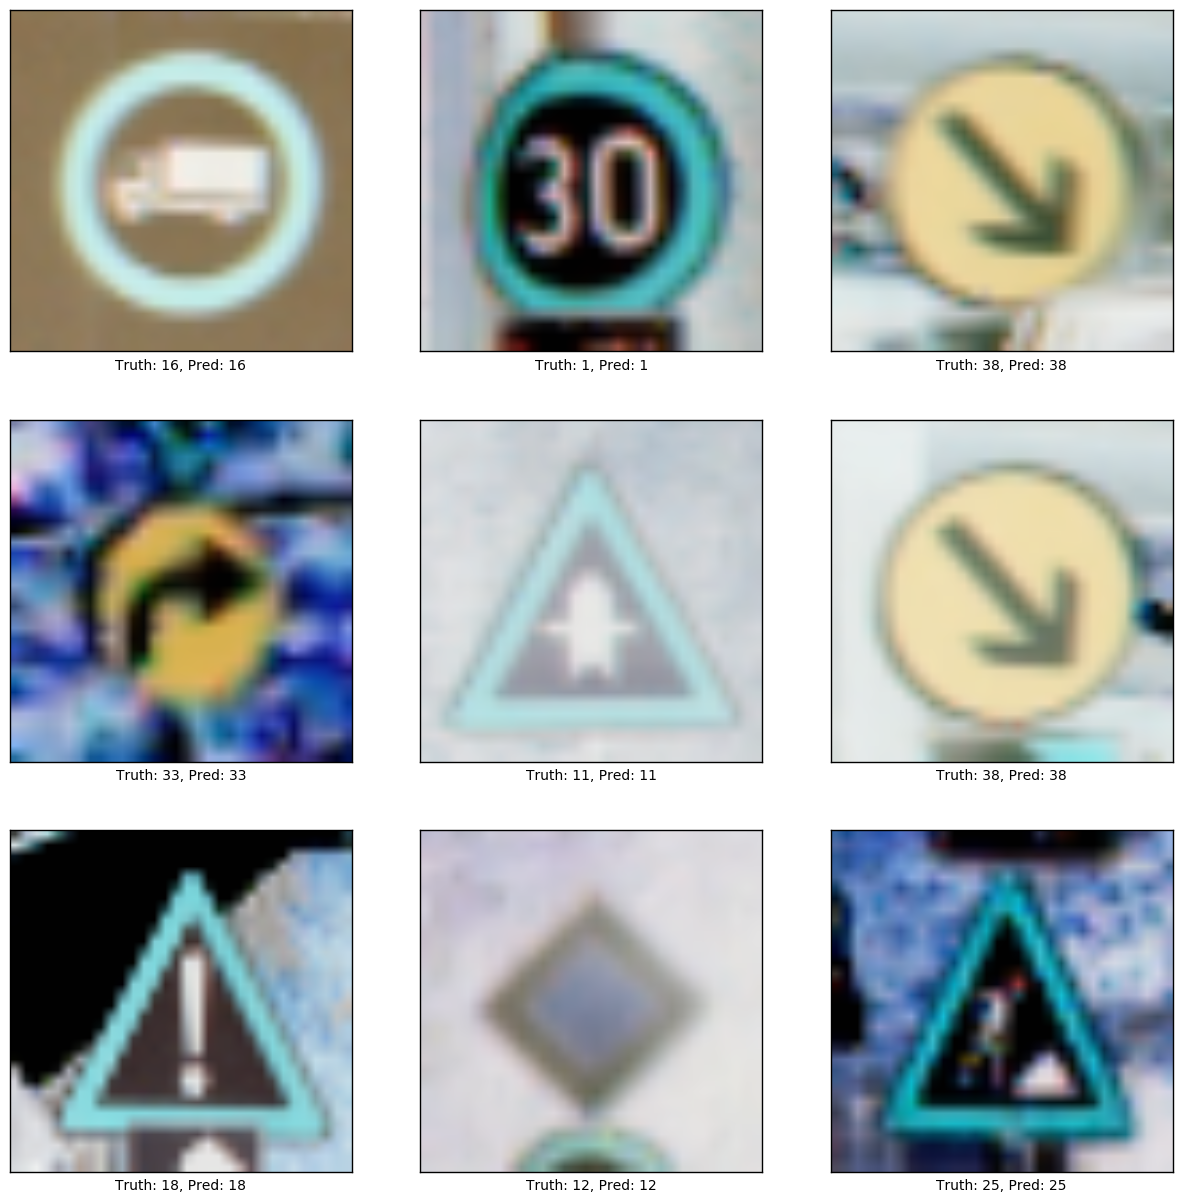

In [12]:
### print a few images and see performance on test set

nine_test_features = X_test[0:9]
nine_test_labels = y_test[:9]
original_test_images = (nine_test_features * 255. + 128.).astype(int)

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    preds = predictions.eval(feed_dict={x: nine_test_features, y: nine_test_labels, keep_prob:1.0})

    titles = ["Truth: %d, Pred: %d"%(nine_test_labels[idx], preds[idx]) for idx in range(len(nine_test_features))]
    show_images(original_test_images, titles, 3)

Classes with low accuracy
Class - Accuracy
27 - 0.500000
30 - 0.686667


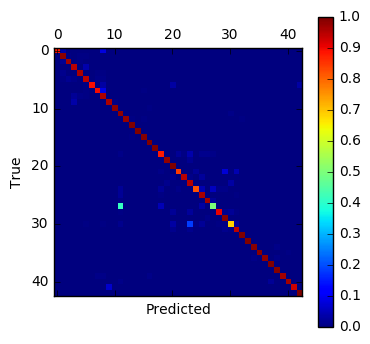

In [13]:
### confusion matrix
from sklearn.metrics import confusion_matrix

def normalize_by_row(arr):
    sum_along_rows = np.sum(arr, axis=1)
    sum_along_rows = sum_along_rows[:, np.newaxis]
    return arr/sum_along_rows

with tf.Session() as sess:
    # Restore variables from disk.
    loader = tf.train.import_meta_graph('model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    preds = predictions.eval(feed_dict={x: X_test, y: y_test, keep_prob:1.0})
    conf_matrix = confusion_matrix(y_test, preds)
    
    conf_matrix = normalize_by_row(conf_matrix)

    plt.matshow(conf_matrix)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    print('Classes with low accuracy')
    print('Class - Accuracy')
    for i in range(n_classes):
        acc = conf_matrix[i][i]
        if acc < 0.75:
            print("%d - %f"%(i, acc))


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

1) Optimizer : I am using adam optimizer since it moving averages of the parameters (momentum). Adam optimizer keeps track of exponentially decaying past momentums and as a result reduces learning rate at each iteration. We dont need to set initial learning rate for Adam optimizer. Adam optimizer will decay this rate over each iteration. I settled with a rate of 0.08 which helped me converge faster.

2) I trained on EC2 machine, and was able to use batch sizes of 64, 128, and 256 without significantly slowing down the system. I settled with batch size of 256.

3)  Validation error reaches quickly to 98% around 50 iterations, but moves up very slowly after that. I continued this for utpto 70 epochs which gave me validation error of 98.2%.

4) For initial weights I am using a mean of 0 with small sigma 0.1 since its recommended to use small initial weights.

5) I am using a 50% dropout for training set, and no dropout for validation and test sets.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

*** Trial and error: ***
I started with LeNet architecture described in the class, which gave me a validation accuracy of around 94%. Increasing number of features at second convolution improved validation accuracy slightly. Adding 2 more fully connected layers gave me validation accuracy of 99%, which I was happy with. But test accuracy was around 90%. This is an indication that my model was overfitting training set. For regularilzation, I added a drop out layer, and initially this dropped my validation accuracy to 97%. After increasing number of epochs and size of fully connected layers, I was able to get 99% validation accuracy, and 94% test accuracy.

*** Pierre Sermanet and Yann LeCun's architecture: ***
I was not content with 94% test accuracy. After reading Pierre Sermanet and Yann LeCun's paper, I liked the idea of using feature outputs from earlier layers (layer1 and 2) along with the last layer(layer 3) before passing them along to fully connected layers. 

I started using 2 convolution layers and flattened both layer 1 and layer 2 outputs and send to a fully connected layer. This initial implementation gave me a test error of 94.2% without much effort. I improved this by adding a third covolution layer, and using 2 fully connected layers(one with drop out) instead of one. After playing with learning rate and number of epochs, I was able to achieve test accuracy of 96%. I am sure if I continued to increase number of epochs, I might be able to push it beyond 97%.

By using outputs from all the convolution layers means we are building more and more complex features, and at the same time using simpler and complex features together in fully connected layers. Convolution layer 1, 2 and 3 outputs will (in my opinion) be able to learn the shape of the plate of the road sign, colors etc, but learning the shapes like children crossing is challenging. In addition to that road signs like deer crossing, pedestrain crossing, road work etc... look very similar at the resolution we have for 32x32 image, especially in poor lighting conditions. Passing layer 1 and 2 output features along to fully connected layers, IMO, helps algorithm learn these complicated signs better.



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

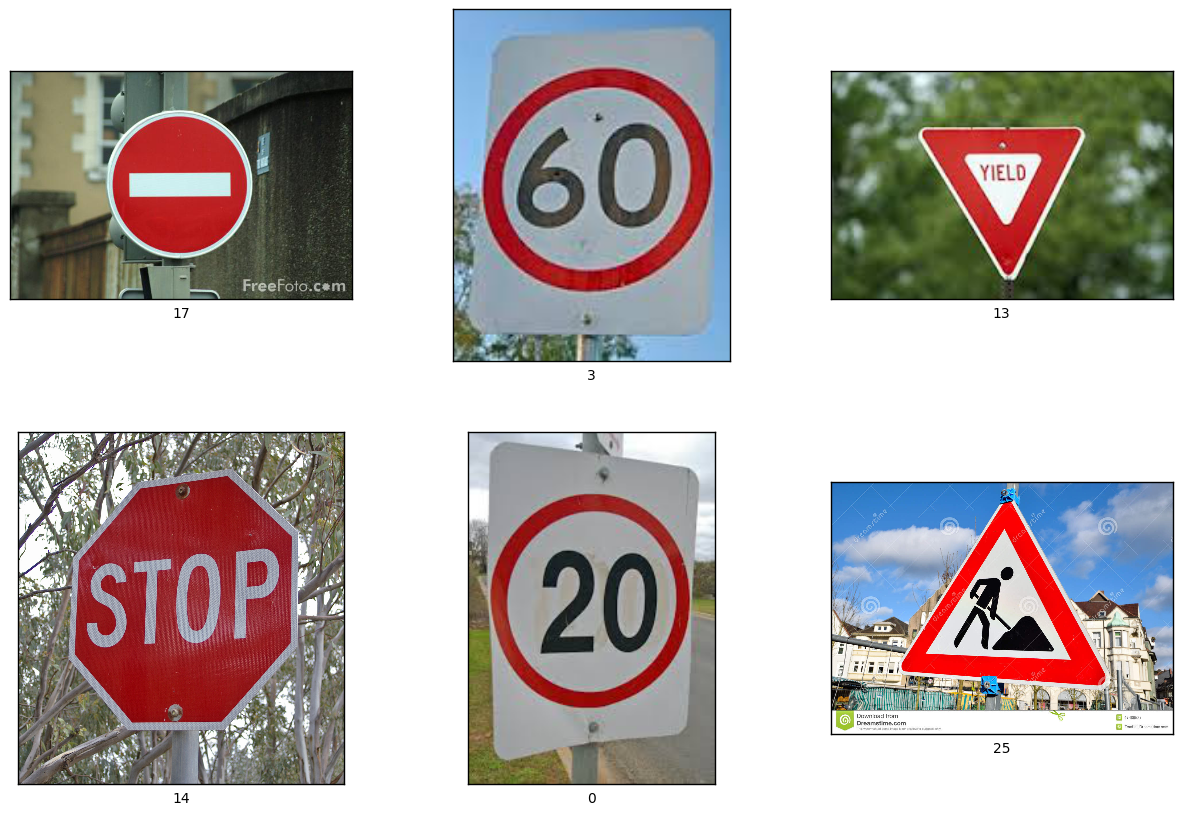

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from os import listdir
import matplotlib.image as mpimg
import cv2

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import numpy as np

path_to_directory = 'new_images'
external_images = []
external_labels = []
external_images_resized = []
for f in listdir(path_to_directory):
    label = int(f.split('_')[0])
    file_path = path_to_directory + "/" + f

    image = cv2.imread(file_path,cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    external_images.append(image)
    external_labels.append(label)
    resized_image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_CUBIC)
    external_images_resized.append(resized_image)
                
external_images_resized = np.asarray(external_images_resized)
external_labels = np.asarray(external_labels)

show_images(external_images, external_labels, 3)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Our training dataset contains road signs which look like full frontal images, and the sign occupies most of the space of the image. In the sample images I picked:

1) road signs are not exactly in the middle of the image

2) signs dont exactly occupy most of the space in the image

3) the signs are in various different perspectives and angles in the sample images. 

Although the sample images are well lit, the reasons mentioned above make classification difficult.

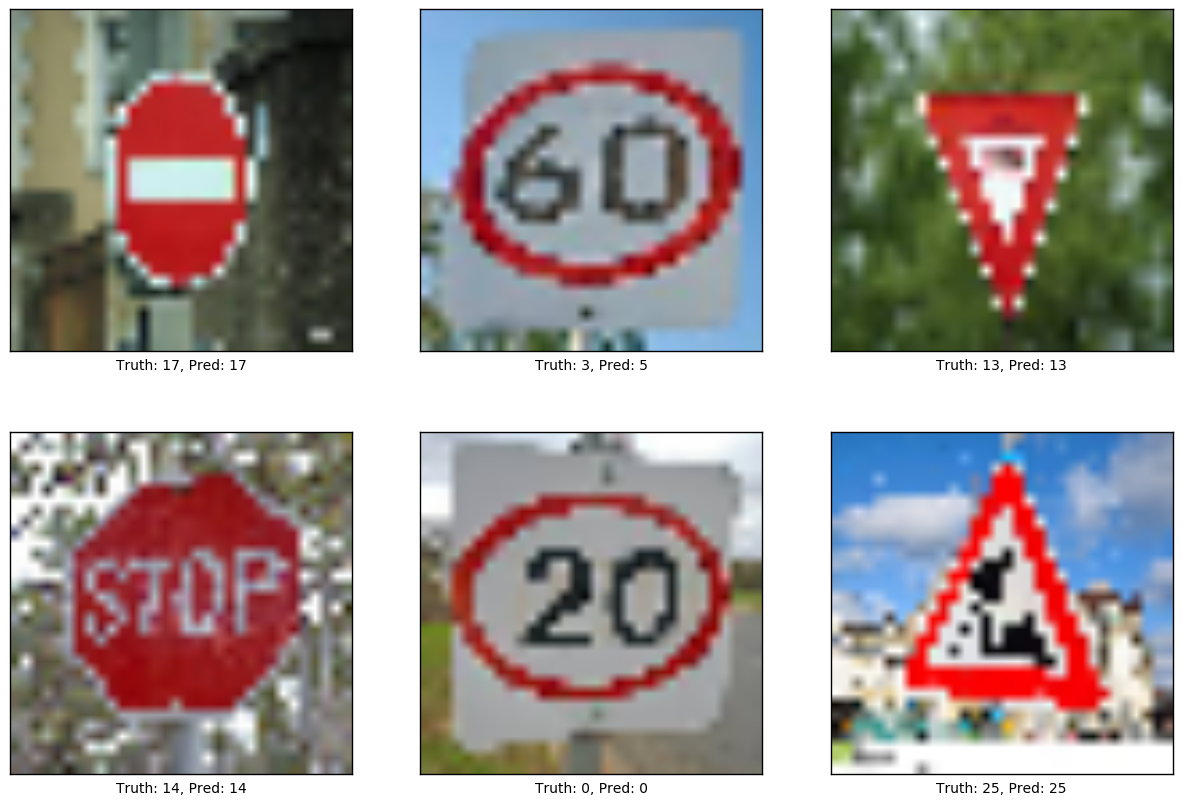

Number of examples: 6, Correct Predictions: 5, Accuracy = 0.833


In [15]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

external_X = make_zero_mean(external_images_resized)
external_y = external_labels

with tf.Session() as sess:
    # Restore variables from disk.
    loader = tf.train.import_meta_graph('model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    dict={x: external_X, y: external_y, keep_prob:1.0}
    
    probabilities = softmax_probabilities.eval(feed_dict=dict)
    preds = predictions.eval(feed_dict=dict)    
    
    top_k_3 = sess.run(tf.nn.top_k(softmax_probabilities, k=3), feed_dict=dict)
    top_k_5 = sess.run(tf.nn.top_k(softmax_probabilities, k=5), feed_dict=dict)
    
    titles = ["Truth: %d, Pred: %d"%(external_labels[idx], preds[idx]) for idx in range(len(external_X))]
    show_images(external_images_resized, titles, 3)
    
    num_correct_predictions = np.count_nonzero(preds == external_labels)
    num_examples = len(external_labels)
    print("Number of examples: %d, Correct Predictions: %d, Accuracy = %.3f"%(num_examples, num_correct_predictions, num_correct_predictions/num_examples))
    

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

My model only predicts 5 out of the 6 new images correctly. This is accuracy of 0.833. This is worse than test accuracy of 96% for the model. Down converting speed limit signs to 32x32 we seem to be loosing critical information, because to a naked eye, downconverted sign 70km/hr looks like 10km/hr. We can improve performance of the model on real life images by increasing augmentation of training images.

In [16]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
print("Printing winning probabilities:")
for idx in range(len(external_labels)):
    print("%.3f"%probabilities[idx][preds[idx]])
    
def get_top_n_info_label(values, indices):
    assert len(values) == len(indices)
    str = ""
    for idx in range(len(indices)):
        str += "%d:%.2f, "%(indices[idx], values[idx])
    return str
        
titles = []
top_3_wins = 0
top_5_wins = 0
for idx in range(len(external_X)):
    truth = external_y[idx]
    top_k_info = get_top_n_info_label(top_k_3.values[idx], top_k_3.indices[idx])
    if truth in top_k_3.indices:
        top_3_wins += 1
    if truth in top_k_5.indices:
        top_5_wins += 1
    titles.append("Truth: %d, TopK: %s"%(truth, top_k_info))

print("Accuracy using top K predictions:")
print("K = 3: %.3f"%(top_3_wins/num_examples))
print("K = 5: %.3f"%(top_5_wins/num_examples))


Printing winning probabilities:
1.000
1.000
0.998
1.000
0.711
0.998
Accuracy using top K predictions:
K = 3: 1.000
K = 5: 1.000


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

# **Answer:**

Accuracy using top K predictions:

K = 3: accuracy = 1.0

K = 5: accuracy = 1.0

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Discussion and next steps:

- We can improve performance of the model on classes where we have accuracy < 75%, by increasing the number of training examples for these classes
- As a next step, I want to use tensor flow visualization tool to visualize the model